In [1]:
import os
import logging
import argparse
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

2025-05-26 21:17:20.200712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748261840.216847 2890691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748261840.221274 2890691 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748261840.231962 2890691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748261840.231981 2890691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748261840.231983 2890691 computation_placer.cc:177] computation placer alr

In [2]:
# GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


I0000 00:00:1748261842.184198 2890691 gpu_device.cc:2019] Created device /device:GPU:0 with 22126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
def load_and_align_data(files: dict, variables: list, mask: float = -1.0):
    idx = None
    for path in files.values():
        df = pd.read_csv(path, parse_dates=['datetime'], index_col='datetime').fillna(mask)
        idx = df.index if idx is None else idx.intersection(df.index)

    data, names = [], []
    for name, path in files.items():
        df = pd.read_csv(path, parse_dates=['datetime'], index_col='datetime').fillna(mask)
        for var in variables:
            if var in df:
                series = df.loc[idx, var].tolist()
                data.append(series)
                names.append(f"{name}_{var}")
    return data, names, idx

In [4]:
def interpolate(seqs: list, mask: float = -1.0) -> list:

    out = []
    for seq in seqs:
        arr = [np.nan if x == mask else x for x in seq]
        df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')
        out.append(df.values.tolist())
    return out


def data_normalize(seqs: list, mask: float = -1.0) -> tuple:
    normalized, params = [], []
    for seq in seqs:
        valid = [v for v in seq if v != mask]
        mn, mx = (min(valid), max(valid)) if valid else (0.0, 1.0)
        norm = [((v - mn) / (mx - mn) if v != mask and mx != mn else v) for v in seq]
        normalized.append(norm)
        params.append((mn, mx))
    return normalized, params


def data_split(seqs: list, T_in: int, T_out: int, offset: int, stride: int) -> tuple:
    X, Y = [], []
    seq_len = len(seqs[0])
    period = T_in + offset + T_out
    for i in range(0, seq_len - period + 1, stride):
        X.append([s[i: i + T_in] for s in seqs])
        Y.append([s[i + T_in + offset: i + T_in + offset + T_out] for s in seqs])
    return np.array(X), np.array(Y)


def split_train(intp: list, norm: list, T_in: int, T_out: int, offset: int, stride: int, split_start: float, split_end: float) -> tuple:
    length = len(intp[0])
    s, e = int(split_start * length), int(split_end * length)
    train_norm = [seq[:s] + seq[e:] for seq in norm]
    test_intp = [seq[s:e] for seq in intp]

    tx, ty = data_split(train_norm, T_in, T_out, offset, stride)
    vx, vy = data_split(test_intp, T_in, T_out, offset, stride)
    return tx, ty, vx, vy



In [5]:
def build_multioutput_model(T_in: int, C: int, T_out: int, tempor_units: int = 64, spatial_units: int = 32, lr: float = 1e-4) -> tf.keras.Model:

    inp = tf.keras.layers.Input((T_in, C))
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(tempor_units, return_sequences=True)
    )(inp)
    x = tf.keras.layers.Permute((2, 1))(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(spatial_units, return_sequences=False)
    )(x)
    out = tf.keras.layers.Dense(T_out * C)(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
    )
    return model

def compute_target_weights(positions, target_pos, alpha=2.0, eps=1e-6):
    coords = np.array(list(positions.values()))
    dists = np.linalg.norm(coords - np.array(target_pos), axis=1)
    w = 1.0 / (dists**alpha + eps)
    return w / w.sum()

In [6]:
def save_predictions_to_csv(predictions: np.ndarray, filename: str, sensor_names: list = None):
    if predictions.ndim == 1:
        predictions = predictions.reshape(1, -1)
    n_cols = predictions.shape[1]
    cols = sensor_names or [f"t{i+1}" for i in range(n_cols)]
    df = pd.DataFrame(predictions, columns=cols)
    df.to_csv(filename, index=False)
    logging.info(f"Saved predictions to '{filename}'")

def evaluate_predictions(preds: np.ndarray, truths: np.ndarray):
    p = preds.ravel()
    t = truths.ravel()
    mae = mean_absolute_error(t, p)
    rmse = np.sqrt(mean_squared_error(t, p))
    r2 = r2_score(t, p)
    mape = mean_absolute_percentage_error(t + 1e-12, p + 1e-12) * 100
    logging.info(f"Metrics -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}


In [7]:
def SP_Learner_multioutput(
    data_in, data_out,
    train_time, test_time, pred_offset, stride,
    start, end,
    tempor_units, spatial_units, lr
):
    # Normalize & interpolate
    norm_in, scale_in = data_normalize(data_in)
    intp_in = interpolate(norm_in)
    # train/test split
    tx, ty, vx, vy = split_train(
        intp_in, norm_in,
        train_time, test_time,
        pred_offset, stride,
        start, end
    )
    # reshape for model
    train_x = tx.transpose(0,2,1)
    train_y = ty.reshape(len(ty), -1)
    val_x   = vx.transpose(0,2,1)
    val_y   = vy.reshape(len(vy), -1)
    C = train_x.shape[2]
    # build & train
    model = build_multioutput_model(
        train_time, C, test_time,
        tempor_units, spatial_units, lr
    )
    es = tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        train_x, train_y,
        epochs=50, batch_size=16,
        validation_split=0.2,
        callbacks=[es], verbose=1
    )
    # predict field
    pred_flat  = model.predict(val_x, verbose=1)
    pred_field = pred_flat.reshape(-1, test_time, C)
    return pred_field, vy, scale_in, model, history


In [8]:
def plot_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss (MAE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Validation/Training loss ratio: {final_val_loss/final_train_loss:.2f}")

    if final_val_loss/final_train_loss > 1.2:
        print("Warning: Validation loss is significantly higher than training loss, which suggests overfitting.")
    elif final_val_loss/final_train_loss < 0.9:
        print("Note: Validation loss is lower than training loss, which suggests underfitting or data distribution differences.")

def plot_training_predictions(train_pred, ty, scaling_params):
    mn, mx = scaling_params[0]
    pred_denorm = train_pred[:, 0, 0] * (mx - mn) + mn
    actual_denorm = ty[:, 0, 0] * (mx - mn) + mn
    n_samples = min(200, len(pred_denorm))
    indices = np.linspace(0, len(pred_denorm)-1, n_samples, dtype=int)
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(actual_denorm[indices], pred_denorm[indices], alpha=0.5)
    min_val = min(np.min(actual_denorm), np.min(pred_denorm))
    max_val = max(np.max(actual_denorm), np.max(pred_denorm))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Predictions vs Actual Values (Training)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot(actual_denorm[indices], 'b-', label='Actual')
    plt.plot(pred_denorm[indices], 'r-', label='Predicted')
    plt.title('Time Series Comparison (Training)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    mae = mean_absolute_error(actual_denorm, pred_denorm)
    rmse = np.sqrt(mean_squared_error(actual_denorm, pred_denorm))
    r2 = r2_score(actual_denorm, pred_denorm)
    print(f"Training data metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

def analyze_indoor_outdoor_relationship(indoor_data, outdoor_data, indoor_names, outdoor_names, time_index):
    data_dict = {name: indoor_data[i] for i, name in enumerate(indoor_names)}
    data_dict.update({name: outdoor_data[i] for i, name in enumerate(outdoor_names)})
    df = pd.DataFrame(data_dict, index=time_index)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Indoor and Outdoor Variables')
    plt.show()

    plt.figure(figsize=(15, 6))
    for i, in_name in enumerate(indoor_names):
        if 'PM2_5' in in_name or 'PM2.5' in in_name:
            plt.plot(time_index, indoor_data[i], label=in_name)
    for i, out_name in enumerate(outdoor_names):
        plt.plot(time_index, outdoor_data[i], label=out_name, linestyle='--')
    plt.title('Indoor vs Outdoor PM2.5 Comparison')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('PM2.5 (normalized)')
    plt.grid(True)
    plt.show()

    for i, in_name in enumerate(indoor_names):
        if 'PM2_5' in in_name or 'PM2.5' in in_name:
            for j, out_name in enumerate(outdoor_names):
                indoor_series = pd.Series(indoor_data[i])
                outdoor_series = pd.Series(outdoor_data[j])
                cross_corr = [indoor_series.corr(outdoor_series.shift(lag)) for lag in range(-24, 25)]
                plt.figure(figsize=(12, 5))
                plt.plot(range(-24, 25), cross_corr)
                plt.axvline(x=0, color='r', linestyle='--')
                plt.title(f'Cross-Correlation between {in_name} and {out_name}')
                plt.xlabel('Lag (minutes)')
                plt.ylabel('Correlation')
                plt.grid(True)
                plt.show()
                best_lag = np.argmax(np.abs(cross_corr)) - 24
                print(f"Optimal lag between {in_name} and {out_name}: {best_lag} minutes (correlation = {cross_corr[best_lag + 24]:.4f})")

def plot_model_comparison(results_with_outdoor, results_without_outdoor, target_var):
    metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
    outdoor_metrics = [results_with_outdoor[target_var][m] for m in metrics]
    baseline_metrics = [results_without_outdoor[target_var][m] for m in metrics]
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, baseline_metrics, width, label='Without Outdoor Data')
    ax.bar(x + width/2, outdoor_metrics, width, label='With Outdoor Data')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_title(f'Model Performance Comparison for {target_var}')

    for i, (base, out) in enumerate(zip(baseline_metrics, outdoor_metrics)):
        if metrics[i] == 'R2':
            improvement = (out - base) / abs(base) * 100 if base != 0 else 0
        else:
            improvement = (base - out) / base * 100 if base != 0 else 0
        color = 'green' if improvement > 0 else 'red'
        ax.text(
            x[i],
            max(base, out) * 1.05,
            f"{improvement:.1f}%",
            ha='center', va='bottom', color=color, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == '__main__':
    # parameters
    train_time  = 335
    test_time   = 30
    pred_offset = 70
    stride      = 15
    start, end  = 0.8, 1.0

    # dữ liệu
    variables = ['PM2_5.ug.m3.']
    base = '/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/'
    files = {f'sensor{i}': f'{base}{i:02d}_01mins.csv' for i in range(1,5)}

    # load & chuẩn bị
    data_all, names_all, idx = load_and_align_data(files, variables)
    data_in  = [data_all[i] for i in range(len(data_all))]
    data_out = [data_all[1]]  # ví dụ bạn muốn dự đoán sensor2

    # train + predict
    pred_field, true_array, scale_params, model, history = SP_Learner_multioutput(
        data_in, data_out,
        train_time, test_time, pred_offset, stride,
        start, end,
        tempor_units=64, spatial_units=32, lr=1e-6
    )

    true_field = np.transpose(true_array, (0, 2, 1))

    print('Predicted field (first window):', pred_field[0])
    print('True field      (first window):', true_field[0])

    # predict ở vị trí mới
    positions = {
        'sensor1': (0,0),
        'sensor2': (1,0),
        'sensor3': (0.5,0.8),
        'sensor4': (0.7,0.3),
    }
    
    new_pos = (0.3, 0.4)
    w_new = compute_target_weights(positions, new_pos, alpha=2.0)
    pred_new = np.tensordot(pred_field, w_new, axes=([2],[0]))
    print('Predicted at new location, first window:', pred_new[0])

    # reshape để đánh giá riêng sensor2 (idx=0)
    sens2_idx = 0
    pred_y = pred_field[:,:,sens2_idx][:,None,:]
    true_y = true_field[:,:,sens2_idx][:,None,:]

    
    print('Done.')

/tmp/ipykernel_2890691/3339566057.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.1747 - val_loss: 0.1114
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.1736 - val_loss: 0.1102
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.1729 - val_loss: 0.1085
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1705 - val_loss: 0.1064
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.1652 - val_loss: 0.1037
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.1628 - val_loss: 0.1004
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.1573 - val_loss: 0.0966
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1547 - val_loss: 0.0923
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.1441 - val_loss: 0.0878
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.1410 - val_loss: 0.0832
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.1339 - val_loss: 0.0790
Epoch 12/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
 pred_new

array([[0.06579018, 0.06670232, 0.06576257, ..., 0.06165973, 0.05957187,
        0.06102638],
       [0.06220479, 0.0626776 , 0.06262269, ..., 0.05793853, 0.05595341,
        0.05709306],
       [0.06224323, 0.06310659, 0.06379374, ..., 0.05780411, 0.05742067,
        0.05770843],
       ...,
       [0.04256498, 0.04278498, 0.04359231, ..., 0.04187661, 0.041837  ,
        0.04140313],
       [0.04449054, 0.04514872, 0.04535981, ..., 0.04358139, 0.04352926,
        0.0433638 ],
       [0.04368954, 0.04480278, 0.04476144, ..., 0.04322699, 0.04334768,
        0.04296786]])

In [14]:
w_new

array([0.24359346, 0.09369002, 0.30449152, 0.358225  ])

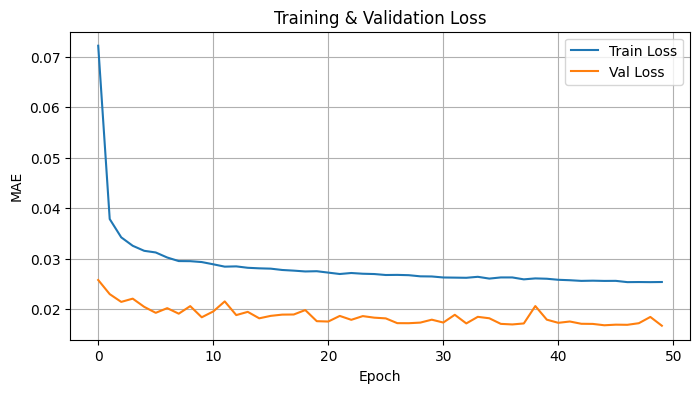

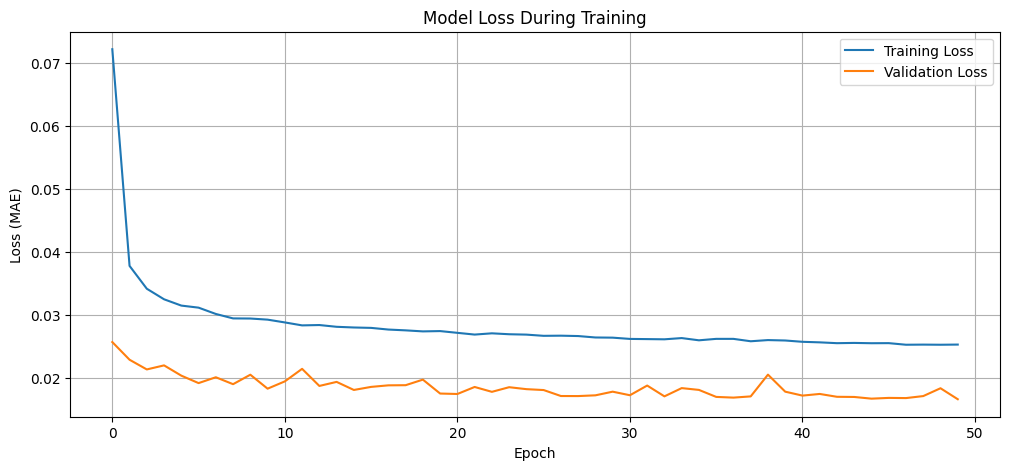

Final training loss: 0.0253
Final validation loss: 0.0167
Validation/Training loss ratio: 0.66
Note: Validation loss is lower than training loss, which suggests underfitting or data distribution differences.


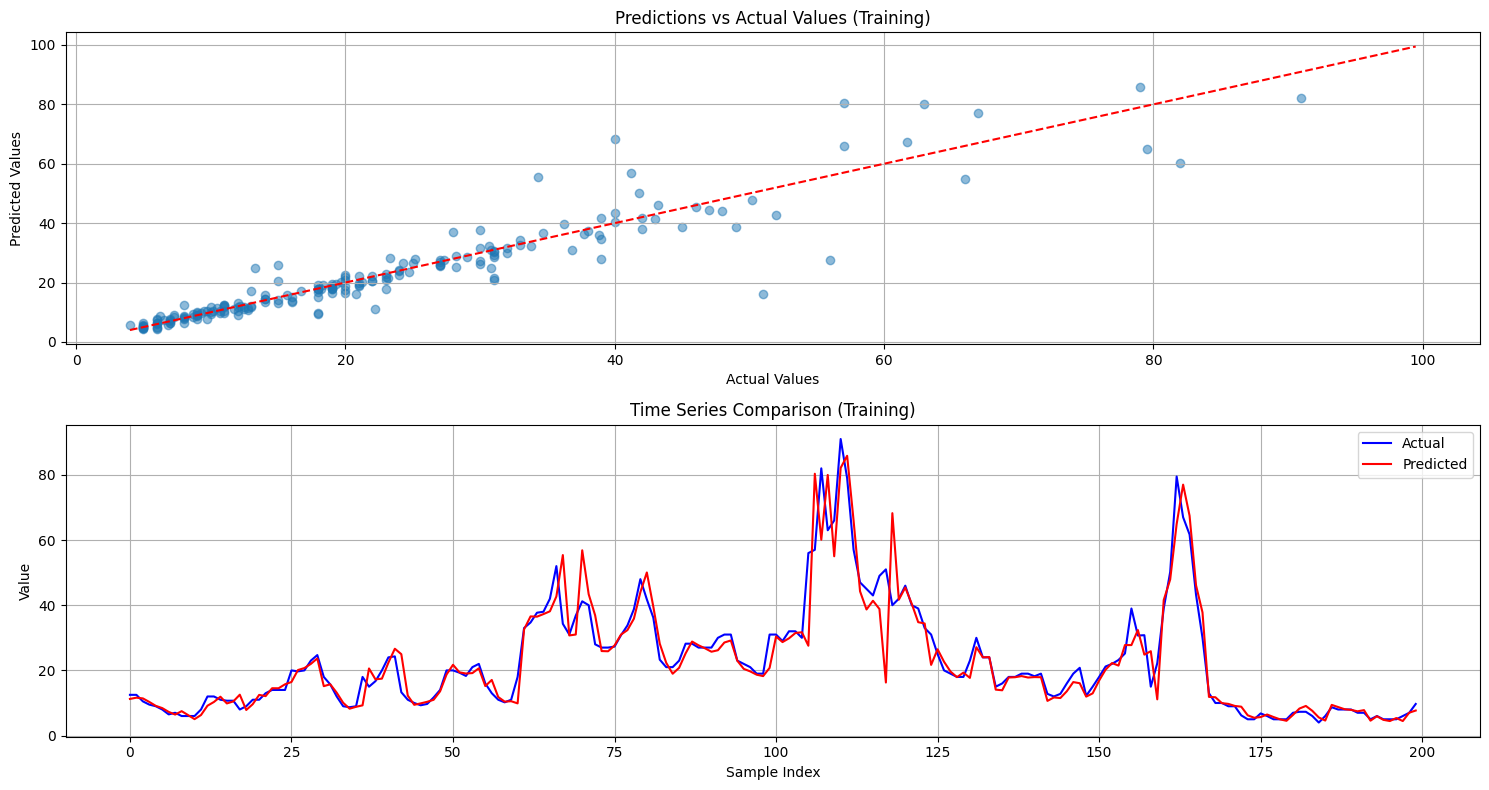

Training data metrics:
MAE: 2.9535
RMSE: 5.7872
R²: 0.8722


In [16]:
plot_loss(history)
plot_training_history(history)

plot_training_predictions(pred_field, true_field, scale_params)